In [ ]:
!pip install pandas
!pip install numpy
!pip install pyarrow
!pip install keras
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install seaborn

In [42]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector, Flatten, Reshape
from keras.callbacks import Callback
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

We will quickly read the data from our ETL pipeline.

In [43]:
x_train = pd.read_csv('data-etl/x_train.csv')
y_train = pd.read_csv('data-etl/y_train.csv')

x_test = pd.read_csv('data-etl/x_test.csv')
y_test = pd.read_csv('data-etl/y_test.csv')

# Model Definition

In [44]:
batch_size = 64
epochs = 15
timesteps = 100
dim = 1

In [45]:
def get_sequences(x, y, timesteps = 1):
    Xs, Ys = [], []
    for i in range(len(x) - timesteps):
        Xs.append(x.iloc[i: (i + timesteps)].values)
        Ys.append(y.iloc[i + timesteps])
        
    return np.array(Xs), np.array(Ys)

In [46]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

46783 46783
44991 44991


In [47]:
x_train, y_train = get_sequences(x_train, y_train, timesteps)
x_test, y_test = get_sequences(x_test, y_test, timesteps)

In [48]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
lossHistory = LossHistory()

In [49]:
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, dim)))
model.add(Dropout(0.2))

model.add(RepeatVector(n=timesteps))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(1, activation= 'sigmoid')))
model.compile(loss='mae', optimizer='adam')

# Model Training

In [50]:
def train(train, test):
    model.fit(train, test, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[lossHistory], shuffle=False)

In [51]:
def predict(data):
    return model.predict(data)

In [52]:
train(x_train, y_train)

Epoch 1/15
657/657 [==============================] - 35s 53ms/step - loss: 0.0087 - val_loss: 3.0990e-05
Epoch 2/15
657/657 [==============================] - 34s 52ms/step - loss: 2.7854e-05 - val_loss: 1.2453e-05
Epoch 3/15
657/657 [==============================] - 34s 52ms/step - loss: 1.3285e-05 - val_loss: 6.5298e-06
Epoch 4/15
657/657 [==============================] - 34s 52ms/step - loss: 7.6073e-06 - val_loss: 3.8488e-06
Epoch 5/15
657/657 [==============================] - 34s 52ms/step - loss: 4.7562e-06 - val_loss: 2.4219e-06
Epoch 6/15
657/657 [==============================] - 34s 52ms/step - loss: 3.1243e-06 - val_loss: 1.5873e-06
Epoch 7/15
657/657 [==============================] - 34s 52ms/step - loss: 2.1150e-06 - val_loss: 1.0693e-06
Epoch 8/15
657/657 [==============================] - 34s 52ms/step - loss: 1.4700e-06 - val_loss: 7.3286e-07
Epoch 9/15
657/657 [==============================] - 34s 52ms/step - loss: 1.0358e-06 - val_loss: 5.0834e-07
Epoch 10/15
65

# Model Evaluation

In [53]:
reconstructions_train = predict(x_train)
train_mae = np.mean(np.abs(reconstructions_train - x_train), axis=1)
train_mae

1459/1459 [==============================] - 12s 8ms/step


array([[0.33391363],
       [0.32448137],
       [0.31527431],
       ...,
       [0.07480977],
       [0.07538818],
       [0.07591325]])

<Axes: ylabel='Count'>

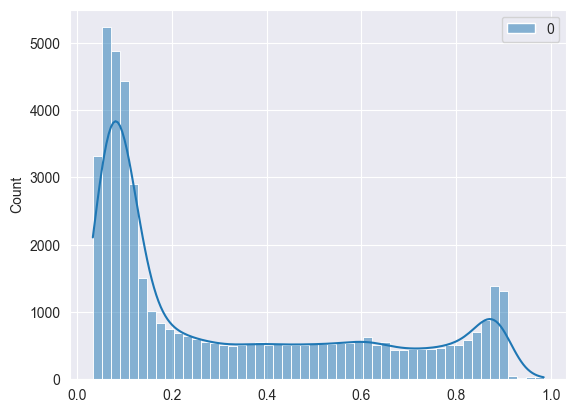

In [54]:
sns.histplot(train_mae, bins = 50, kde=True)

In [55]:
threshold = 0.9

In [56]:
reconstructions_test = predict(x_test)
test_mae = np.mean(np.abs(reconstructions_test - x_test), axis=1)

1403/1403 [==============================] - 11s 8ms/step


<Axes: ylabel='Count'>

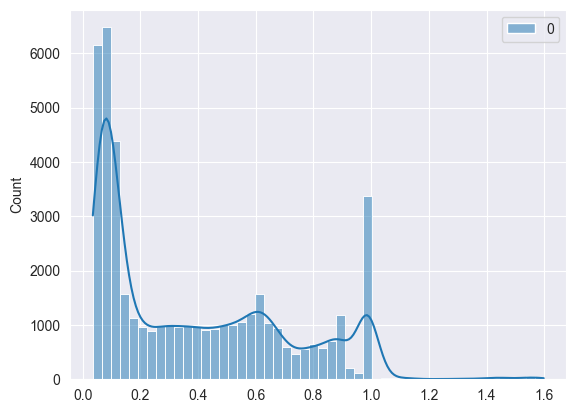

In [57]:
sns.histplot(test_mae, bins = 50, kde=True)

In [59]:
x_test = pd.read_csv('data-etl/x_test.csv')
y_test = pd.read_csv('data-etl/y_test.csv')
y_test = y_test[y_test.columns[1]]

test_df = pd.DataFrame(index = x_test[timesteps:].index)
test_df['Loss'] = test_mae
test_df['Threshold'] = threshold
test_df['Anomaly'] = test_df.Loss > test_df.Threshold

In [61]:
anomalies = test_df[test_df['Anomaly'] == True]

In [63]:
print(metrics.classification_report(y_test[timesteps:], test_df['Anomaly'], zero_division=0.0))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     41478
         1.0       0.72      0.94      0.81      3413

    accuracy                           0.97     44891
   macro avg       0.86      0.95      0.90     44891
weighted avg       0.97      0.97      0.97     44891
